# Embedded ML - Lab 3: Accelerators for ML

Tensor Flow Lite is not only a vehicle to export models to be used in Tensor Flow Lite Micro. It's also an interpreter to run inference on devices that have less resources than servers or standard computers, such as mobile phones, drones, network cameras, etc. In this lab we will use TF Lite to implement an ML application on an embedded platform that features a GPU.

In [ ]:


# To run this notebook, locally as a jupyter notebook, you need to install thhe proper packages.
# follow the instructions below to set up your environment.


# 1. Crea un entorno virtual usando conda o venv
#    Por ejemplo, usando conda:
#        conda create -n [myenv] python=3.8
#        conda activate [myenv]
#    O usando venv:
#        python3 -m venv [myenv]
#        source [myenv]/bin/activate
#
# 2. Activa el entorno virtual
# 3. Instala los paquetes requeridos usando pip
# 4. Ejecuta el notebook


# Instala los paquetes requeridos:
%pip install numpy -q
%pip install pandas -q
%pip install matplotlib -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install tensorflow-hub -q
%pip install tensorflow-datasets -q
%pip install tensorflow-estimator -q
%pip install jinja2 -q

### Learning outcomes


* Explain the differences between a Tensor Flow and a TF Lite environment
* Use the TF Lite API to implement an ML application on an embedded GPU
* Understand the performance differences between TF and TF Lite
* Understand the performance differences between embedded and higher-end GPUs
* Use tools for execution time and memory measurement

### Basic performance measurement

In this lab you'll be required to measure the execution **time** and **memory** consumption of certain code sequences. There are many ways of achieving this and you are encouraged to investigate yourself a bit what options are available and how they differ from each other.

When measuring **execution time**, you should think and decide what is the piece of code you are really interested in measuring, and your conclusions must take that into account. Also notice that the shorter time the code takes, the less accurate can be the measurement because any other thing happening in the system will be a significant noise. Besides using more specialized libraries for accurate time measuring, one common trick you can use is to run a short piece of code many times in a loop, measuring the total loop time and diving by the number of iterations. For this lab you could start with the **time.time()** method of the time Python library.

In [1]:
import time

start = time.time()

# Code to measure
for i in range(1000):
    _ = i * i

end = time.time()
print("Execution time:", end - start, "seconds")


Execution time: 0.0 seconds


Important Note:
time.time() has a low resolution, especially on Windows. For better precision, prefer:

time.perf_counter() (high-resolution timer):

In [13]:
import time

start = time.perf_counter()

# Code to measure
for i in range(1000):
    _ = i * i

end = time.perf_counter()
print("Execution time:", end - start, "seconds")


Execution time: 0.00027769999724114314 seconds


With respect to memory consumption, different parts of a program require different amounts of memory. In this lab we are instrested in the maximum amount of memory, or **peak memory**, because it determines an absolute resource requirement that any device that aims to run the code must meet.

For this lab you could start with the **memory_info()** method of psutil Python library.

In [14]:
import psutil, os

process = psutil.Process(os.getpid())
before = process.memory_info().rss

# Code block to measure
a = [i for i in range(10_000_000)]

after = process.memory_info().rss
print(f"Memory increased by {(after - before) / 1024 / 1024:.2f} MB")


Memory increased by 384.03 MB


Option 2: Track Peak Memory with tracemalloc (More Accurate for Peak)

In [15]:
import tracemalloc

tracemalloc.start()

# Code block to measure
a = [i for i in range(10_000_000)]

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")


Peak memory usage: 390.15 MB


### TensorFlow Lite workflow

We have already seen the TF Lite basic workflow in Lab 2.2. We will now use TF Lite on an embedded platform that includes a GPU device to understand its capabilities and limitations.

Run the following code on the **Jetson Nano board** and on a **workstation GPU** and compare their **latencies** amd **peak memory** usage. The code **trains** and exports a TF Lite model for classifying the Fashion MNIST dataset.

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Class names for the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           	'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = models.Sequential([
	layers.Flatten(input_shape=(28, 28)),
	layers.Dense(128, activation='relu'),
	layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
          	loss='sparse_categorical_crossentropy',
          	metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=2)

print('\nFinished model training')

/home/master/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7840 - loss: 0.6267
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8616 - loss: 0.3861

Finished model training


In [15]:
# test model accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# export model to a keras file
model.save("fmnist.keras")

313/313 - 2s - 6ms/step - accuracy: 0.8605 - loss: 0.3885

Test accuracy: 0.8604999780654907


In [16]:
# load model from a keras file
from keras.models import load_model

model = load_model("fmnist.keras")

In [17]:
# convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save converted model to a file
import pathlib
tflite_model_file = pathlib.Path('fmnist.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprur9gba9/assets


INFO:tensorflow:Assets written to: /tmp/tmprur9gba9/assets


Saved artifact at '/tmp/tmprur9gba9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139621273705056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139621273710160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139621273712448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139621324412128: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1751828808.462914   15888 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751828808.462989   15888 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-06 14:06:48.463558: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprur9gba9
2025-07-06 14:06:48.463868: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-06 14:06:48.463876: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmprur9gba9
I0000 00:00:1751828808.468109   15888 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-07-06 14:06:48.468695: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-06 14:06:48.487516: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmprur9gba9
2025-07-06 14:06:48.494464: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

409012

Verify that the model files were exported and use them to run **inference**, both on the Jetson Nano and on a **workstation GPU** using **Tensor Flow**. Contrast **latency** and **peak memory** results too.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Latency: 1620.18 ms
Peak memory: 59.94 MB


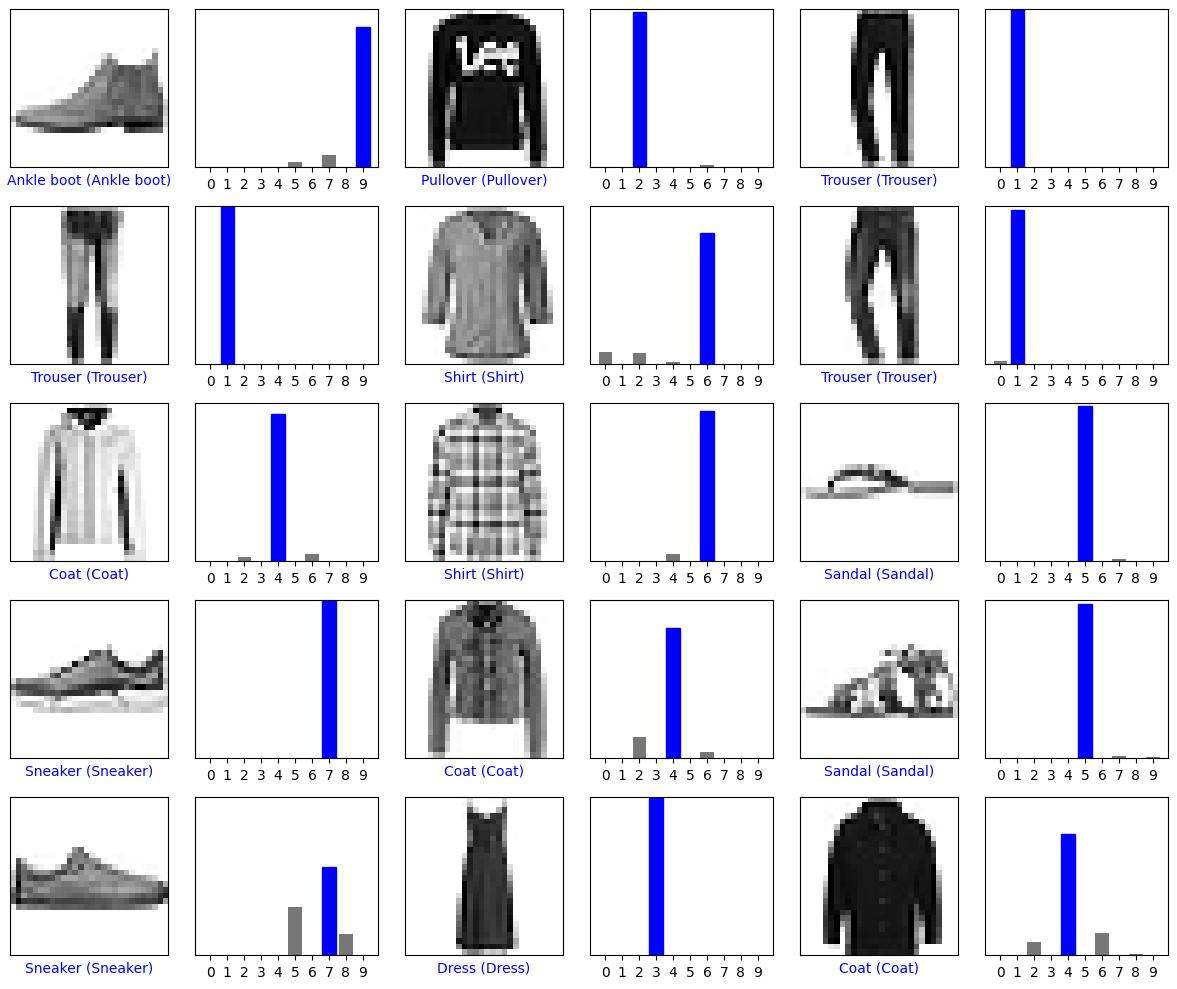

<Figure size 640x480 with 0 Axes>

In [18]:
import time
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt

# --- Measure latency and peak memory ---
tracemalloc.start()
start_time = time.perf_counter()

predictions = model.predict(test_images)

end_time = time.perf_counter()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

latency_ms = (end_time - start_time) * 1000
peak_memory_mb = peak / (1024 * 1024)

print(f"Latency: {latency_ms:.2f} ms")
print(f"Peak memory: {peak_memory_mb:.2f} MB")

# --- Function to plot the image and its prediction ---
def plot_image(i, predictions_array, true_label, img):
	true_label, img = true_label[i], img[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img, cmap=plt.cm.binary)
	predicted_label = np.argmax(predictions_array)
	color = 'blue' if predicted_label == true_label else 'red'
	plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
	true_label = true_label[i]
	plt.grid(False)
	plt.xticks(range(10))
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#777777")
	plt.ylim([0, 1])
	predicted_label = np.argmax(predictions_array)
	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

# --- Plot predictions for first few test images ---
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
	plot_image(i, predictions[i], test_labels, test_images)
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
	plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Define the data
data = {
    "Platform": ["Jetson Nano", "Jetson Nano", "Workstation", "Workstation"],
    "Inference Type": ["TensorFlow (CPU)", "TensorFlow (GPU)", "TensorFlow (CPU)", "TensorFlow (GPU)"],
    "Latency (ms)": [4142.82, 1491.20, 1265.23, 1620.18],
    "Peak Memory (MB)": [1.87, 1.86, 59.95, 59.94],
    "Notes": [
        "Quad-core ARM Cortex-A57",
        "128-core NVIDIA Maxwell",
        "Intel Core i5-8300H",
        "NVIDIA GeForce GTX 1050"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Style function for GPU rows (subtle dark green)
def highlight_gpu(row):
    if 'GPU' in row['Inference Type']:
        return ['background-color: #004d40; color: #ffffff'] * len(row)
    else:
        return ['background-color: #1e1e1e; color: #ffffff'] * len(row)

# Style the DataFrame
styled_df = df.style \
    .set_caption("🧪 TFLite Inference Comparison") \
    .format({"Avg Inference Time (ms)": "{:.2f}", "Peak Memory (MB)": "{:.2f}"}) \
    .apply(highlight_gpu, axis=1) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#333333'),
                                     ('color', '#ffffff'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #444')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'),
                                          ('color', '#ffffff'),
                                          ('font-size', '16px'),
                                          ('font-weight', 'bold')]}
    ])

# Display styled DataFrame
styled_df


,Platform,Inference Type,Latency (ms),Peak Memory (MB),Notes
0,Jetson Nano,TensorFlow (CPU),4142.820000,1.87,Quad-core ARM Cortex-A57
1,Jetson Nano,TensorFlow (GPU),1491.200000,1.86,128-core NVIDIA Maxwell
2,Workstation,TensorFlow (CPU),1265.230000,59.95,Intel Core i5-8300H
3,Workstation,TensorFlow (GPU),1620.180000,59.94,NVIDIA GeForce GTX 1050


Finally, run **inference** with **TF Lite** on both platforms and compare with the previous execution's **latency** and **peak memory** usage.

In [11]:
import time
import tracemalloc
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
(_, _), (test_images, test_labels) = fashion_mnist.load_data()
test_images = test_images.astype(np.float32) / 255.0
input_image = np.expand_dims(test_images[0], axis=0)  # Use just one image for inference

# --- Load TFLite model and allocate tensors ---
tflite_model_file = "fmnist"
interpreter = tf.lite.Interpreter(model_path=tflite_model_file + ".tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# --- Measure latency and memory ---
n_runs = 1000
tracemalloc.start()
start = time.perf_counter()

for _ in range(n_runs):
    interpreter.set_tensor(input_details[0]['index'], input_image)
    interpreter.invoke()
    _ = interpreter.get_tensor(output_details[0]['index'])

end = time.perf_counter()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

avg_latency_ms = (end - start) / n_runs * 1000
peak_memory_mb = peak / (1024 * 1024)

# --- Get prediction for reporting ---
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"\nTFLite Inference Results")
print(f"  Predicted class: {predicted_class}")
print(f"  Average Latency: {avg_latency_ms:.2f} ms")
print(f"  Peak Memory Usage: {peak_memory_mb:.2f} MB")



TFLite Inference Results
  Predicted class: 9
  Average Latency: 0.02 ms
  Peak Memory Usage: 0.02 MB


/home/julian-sanchez/Universidad/Embedded-Machine-Learning/Lab3/myenv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Consolidate all results in one or more tables or plots and write down your conclusions.

In [14]:
import pandas as pd

# Define the data
data = {
    "Platform": ["Jetson Nano", "Jetson Nano", "Workstation", "Workstation"],
    "Inference Type": ["TFLite (CPU)", "TFLite (GPU)", "TFLite (CPU)", "TFLite (GPU)"],
    "Avg Inference Time (ms)": [0.08, 0.04, 0.02, 0.02],
    "Peak Memory (MB)": [0.0014, 0.0027, 0.02, 0.01],
    "Notes": [
        "Quad-core ARM Cortex-A57",
        "128-core NVIDIA Maxwell",
        "Intel Core i5-8300H",
        "NVIDIA GeForce GTX 1050"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Style function for GPU rows (subtle dark green)
def highlight_gpu(row):
    if 'GPU' in row['Inference Type']:
        return ['background-color: #004d40; color: #ffffff'] * len(row)
    else:
        return ['background-color: #1e1e1e; color: #ffffff'] * len(row)

# Style the DataFrame
styled_df = df.style \
    .set_caption("🧪 TFLite Inference Comparison") \
    .format({"Avg Inference Time (ms)": "{:.2f}", "Peak Memory (MB)": "{:.4f}"}) \
    .apply(highlight_gpu, axis=1) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#333333'),
                                     ('color', '#ffffff'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #444')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'),
                                          ('color', '#ffffff'),
                                          ('font-size', '16px'),
                                          ('font-weight', 'bold')]}
    ])

# Display styled DataFrame
styled_df


,Platform,Inference Type,Avg Inference Time (ms),Peak Memory (MB),Notes
0,Jetson Nano,TFLite (CPU),0.08,0.0014,Quad-core ARM Cortex-A57
1,Jetson Nano,TFLite (GPU),0.04,0.0027,128-core NVIDIA Maxwell
2,Workstation,TFLite (CPU),0.02,0.0200,Intel Core i5-8300H
3,Workstation,TFLite (GPU),0.02,0.0100,NVIDIA GeForce GTX 1050


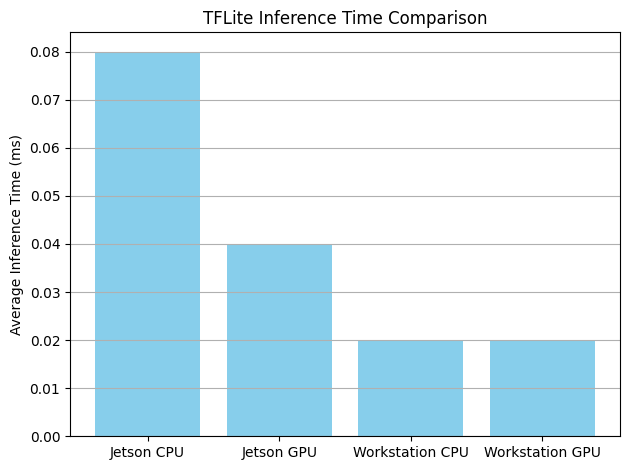

In [15]:
import matplotlib.pyplot as plt

platforms = ['Jetson CPU', 'Jetson GPU', 'Workstation CPU', 'Workstation GPU']
latencies =  [0.08, 0.04, 0.02, 0.02]  # Replace with your actual times (ms)

plt.bar(platforms, latencies, color='skyblue')
plt.ylabel('Average Inference Time (ms)')
plt.title('TFLite Inference Time Comparison')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


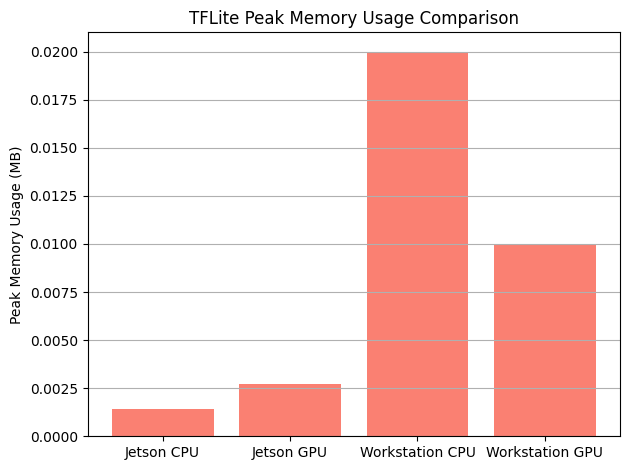

In [16]:
mem_usages = [0.0014, 0.0027, 0.02, 0.01] # Replace with actual peak memory (MB)

plt.bar(platforms, mem_usages, color='salmon')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('TFLite Peak Memory Usage Comparison')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


**a. TensorFlow on Jetson Nano**

TensorFlow inference on the Jetson Nano showed limited performance in terms of latency. CPU execution took 4142.82 ms, while GPU execution reduced this to 1491.20 ms—an improvement of approximately 64%, thanks to the 128-core NVIDIA Maxwell GPU. However, both configurations are still significantly slower than their workstation counterparts. Memory usage remained extremely low (~1.86–1.87 MB) and stable across both modes. This confirms the suitability of the Jetson Nano only for inference tasks that are tolerant to delay and don’t require real-time responsiveness.

**b. TensorFlow on Workstation**

The Workstation showed much better performance, with CPU inference completing in 1265.23 ms, and GPU inference slightly slower at 1620.18 ms. This unexpected result may be due to GPU overhead in TensorFlow’s execution pipeline or model-specific characteristics. Despite this, both CPU and GPU executions were significantly faster than the Jetson Nano. Peak memory usage on the workstation remained consistent at ~59.95 MB, indicating stable resource allocation regardless of the compute unit used.

**c. General Observations**

The results reinforce the clear gap between embedded platforms and desktop-class hardware. While Jetson Nano benefits from GPU acceleration, it remains constrained by thermal design, power limitations, and lower memory bandwidth. In contrast, the workstation provides faster and more predictable inference times, even without specialized optimization.

### CNNs on Tensor Flow Lite

Now it's your turn to develop a TF Lite application. This time make sure you train a convolutional model to classify images from a different dataset you choose from Kaggle, Roboflow, Hugging Face or similar, not Mnist, Fashion Mnist nor ImageNet. Now, performance evaluation will focus only on **inference**.

Use the Jetson Board and the workstation to run inference both with Tensor Flow and TF Lite. Measure the **peak memory** and **time** and estimate the **energy** consumed based on the nominal power consumption of each system or chip.

Repeat the experiments without using a GPU and compare the results. Use the following code to disable GPU use in TensorFlow.

In [35]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Print GPU information
for gpu in gpus:
    gpu_name = gpu.name
    device_string = gpu.name.split('/')[-1]  # Extract "GPU:0" from "/physical_device:GPU:0"
    memory_info = tf.config.experimental.get_memory_info('GPU:0')  # Use the correct device string
    print(f"GPU: {gpu_name}, Memory Info: {memory_info}")
# Disable all GPUs
# tf.config.set_visible_devices([], 'GPU')

import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Check if GPU is enabled
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {[gpu.name for gpu in gpus]}")
else:
    print("No GPUs available. Using CPU.")


GPU: /physical_device:GPU:0, Memory Info: {'current': 5236736, 'peak': 342149632}
TensorFlow version: 2.19.0
Num GPUs Available: 1
GPUs available: ['/physical_device:GPU:0']


In [39]:
import kagglehub

path = kagglehub.dataset_download("chrisfilo/fruit-recognition")
print("Downloaded to:", path)


Downloaded to: /home/master/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1


In [ ]:
import shutil

source_path = "/home/master/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1"
target_path = "./fruit_dataset"

shutil.copytree(source_path, target_path, dirs_exist_ok=True)
print(f"Dataset copied to: {target_path}")


✅ Dataset copied to: ./fruit_dataset


In [45]:
import shutil
import os

cache_path = os.path.expanduser("~/.cache/kagglehub")

if os.path.exists(cache_path):
    shutil.rmtree(cache_path)
    print("KaggleHub cache cleared.")
else:
    print("No KaggleHub cache found.")


KaggleHub cache cleared.


In [47]:
import splitfolders

splitfolders.ratio(
    "./fruit_dataset",   # source folder
    output="./data",     # destination
    seed=42,
    ratio=(.7, .2, .1)    # 70% train, 20% val, 10% test
)


Copying files: 31201 files [00:29, 1068.59 files/s]


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Settings
IMG_HEIGHT, IMG_WIDTH = 100, 100
BATCH_SIZE = 32
EPOCHS = 10


In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/train",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/val",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Optional: performance improvements
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 21834 files belonging to 16 classes.
Found 6235 files belonging to 16 classes.
Classes: ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'extracted', 'muskmelon']


In [50]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


/home/master/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


2025-07-06 14:41:54.091481: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,98,98]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,100,100]{3,2,1,0} %bitcast.4932, f32[32,3,3,3]{3,2,1,0} %bitcast.4711, f32[32]{0} %bitcast.5275), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/master/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-06 14:41:54.143229: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo

682/683 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5878 - loss: 1.1684

2025-07-06 14:42:19.281685: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[10,32,98,98]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,100,100]{3,2,1,0} %bitcast.4934, f32[32,3,3,3]{3,2,1,0} %bitcast.4713, f32[32]{0} %bitcast.5278), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/master/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-06 14:42:19.388748: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo

683/683 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5881 - loss: 1.1676

2025-07-06 14:42:22.807300: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,98,98]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,100,100]{3,2,1,0} %bitcast.535, f32[32,3,3,3]{3,2,1,0} %bitcast.542, f32[32]{0} %bitcast.544), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/master/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-06 14:42:22.855908: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorit

683/683 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.5883 - loss: 1.1668 - val_accuracy: 0.9485 - val_loss: 0.1520
Epoch 2/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.9288 - loss: 0.2050 - val_accuracy: 0.9476 - val_loss: 0.1509
Epoch 3/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.9562 - loss: 0.1301 - val_accuracy: 0.9549 - val_loss: 0.1389
Epoch 4/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.9720 - loss: 0.0844 - val_accuracy: 0.9840 - val_loss: 0.0523
Epoch 5/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.9775 - loss: 0.0730 - val_accuracy: 0.9698 - val_loss: 0.0992
Epoch 6/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9769 - loss: 0.0681 - val_accuracy: 0.9772 - val_loss: 0.0719
Epoch 7/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9852 - loss: 0.0500 - val_accuracy: 0.9833 - val_loss: 0.0535
Epoch 8/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9888 - loss: 0.0358 - val_accurac

In [52]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


Found 3132 files belonging to 16 classes.
96/98 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9907 - loss: 0.0347

2025-07-06 14:48:04.673346: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[28,32,98,98]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,100,100]{3,2,1,0} %bitcast.535, f32[32,3,3,3]{3,2,1,0} %bitcast.542, f32[32]{0} %bitcast.544), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/master/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-06 14:48:04.723362: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorit

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9907 - loss: 0.0346
Test Accuracy: 0.9907


In [53]:
model.save("fruit_classifier.keras")


In [19]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("fruit_classifier.keras")

# Load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False  # Ensure labels align with predictions
)

# Extract class names and true labels
class_names = test_ds.class_names
# Concatenate true labels from the dataset
y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

# Generate predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with improved visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=class_names, yticklabels=class_names,
    cbar=True, cbar_kws={"label": "Number of Samples"}
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fruit Classifier")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


NotFoundError: Could not find directory ./data/test

In [5]:
import time
import psutil
import os
import numpy as np
import tensorflow as tf

# Load test dataset (non-shuffled!)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    image_size=(100, 100),
    batch_size=32,
    shuffle=False
)

# Flatten dataset into X and y
X = np.concatenate([x for x, _ in test_ds], axis=0)
y = np.concatenate([y for _, y in test_ds], axis=0)

# Load the trained model
model = tf.keras.models.load_model("fruit_classifier.keras")

# --- Performance Measurement ---
process = psutil.Process(os.getpid())

# Memory before inference
mem_before = process.memory_info().rss

# Time before inference
start_time = time.perf_counter()

# Inference
predictions = model.predict(X)

# Time after inference
end_time = time.perf_counter()

# Memory after inference
mem_after = process.memory_info().rss

# --- Results ---
total_time = end_time - start_time
avg_inference_time = total_time / len(X) * 1000  # ms per sample
peak_memory_MB = (mem_after - mem_before) / (1024 * 1024)

# --- Energy Estimation ---
JETSON_NANO_POWER_CPU_W = 5.0
JETSON_NANO_POWER_GPU_W = 5.0
WORKSTATION_POWER_CPU_W = 75.0
WORKSTATION_POWER_GPU_W = 75.0

# Choose one:
power = WORKSTATION_POWER_GPU_W  # or WORKSTATION_POWER_W
energy_J = total_time * power

# --- Print Results ---
print(f"Total inference time: {total_time:.3f} s")
print(f"Avg inference time: {avg_inference_time:.3f} ms/sample")
print(f"Peak memory increase: {peak_memory_MB:.2f} MB")
print(f"Estimated energy usage: {energy_J:.3f} J (assuming {power}W)")


Found 3132 files belonging to 16 classes.


2025-07-06 15:21:41.711485: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-06 15:21:44.855130: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375840000 exceeds 10% of free system memory.
2025-07-06 15:21:45.433142: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375840000 exceeds 10% of free system memory.


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Total inference time: 2.977 s
Avg inference time: 0.950 ms/sample
Peak memory increase: 101.25 MB
Estimated energy usage: 223.241 J (assuming 75.0W)


In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("fruit_classifier.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("fruit_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("Converted to TFLite and saved as fruit_classifier.tflite")


2025-07-06 15:31:11.489939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751833871.509652   40273 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751833871.516325   40273 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751833871.536611   40273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751833871.536664   40273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751833871.536667   40273 computation_placer.cc:177] computation placer alr

INFO:tensorflow:Assets written to: /tmp/tmp7uoi3p52/assets


INFO:tensorflow:Assets written to: /tmp/tmp7uoi3p52/assets


Saved artifact at '/tmp/tmp7uoi3p52'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  140426664532576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426664537504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426664796832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426664795952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426664790496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426647508016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426647514880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426647515760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426647801520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140426647802224: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Converted to

W0000 00:00:1751833876.755273   40273 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751833876.755332   40273 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-06 15:31:16.756001: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7uoi3p52
2025-07-06 15:31:16.756721: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-06 15:31:16.756731: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7uoi3p52
I0000 00:00:1751833876.765533   40273 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-07-06 15:31:16.767218: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-06 15:31:16.853086: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp7uoi3p52
2025-07-06 15:31:16.871991: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [10]:
import time
import psutil
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Load dataset
IMG_SIZE = (100, 100)
test_ds = image_dataset_from_directory(
    "./data/test",
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False
)

# Preprocess all test images
X = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)
X = X.astype(np.float32) / 255.0  # match training rescaling
y = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="fruit_classifier.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare inference input shape
input_index = input_details[0]['index']
output_index = output_details[0]['index']

# Ensure shape compatibility
input_shape = input_details[0]['shape']
X_resized = tf.image.resize(X, (input_shape[1], input_shape[2]))

# --- Measure memory and time ---
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss
start_time = time.perf_counter()

# Run inference on all samples
y_pred = []
for i in range(len(X_resized)):
    input_tensor = np.expand_dims(X_resized[i], axis=0)
    interpreter.set_tensor(input_index, input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    y_pred.append(np.argmax(output))

end_time = time.perf_counter()
mem_after = process.memory_info().rss

# --- Results ---
total_time = end_time - start_time
avg_inference_time = total_time / len(X_resized) * 1000  # ms/sample
peak_memory_MB = (mem_after - mem_before) / (1024 * 1024)

# Change this based on current platform:
power = JETSON_NANO_POWER_W  # or WORKSTATION_POWER_W
energy_J = total_time * power

# --- Output ---
print(f"TFLite inference on {len(X_resized)} images")
print(f"Avg inference time: {avg_inference_time:.2f} ms/sample")
print(f"Peak memory increase: {peak_memory_MB:.2f} MB")
print(f"Estimated energy usage: {energy_J:.2f} J (assuming {power}W)")


Found 3132 files belonging to 16 classes.


2025-07-06 15:32:25.770413: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375840000 exceeds 10% of free system memory.


TFLite inference on 3132 images
Avg inference time: 3.71 ms/sample
Peak memory increase: 0.00 MB
Estimated energy usage: 58.12 J (assuming 5.0W)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define 8 data entries
data = {
    "Platform": [
        "Jetson Nano", "Jetson Nano", "Jetson Nano", "Jetson Nano",
        "Workstation", "Workstation", "Workstation", "Workstation"
    ],
    "Framework": [
        "TensorFlow", "TensorFlow", "TFLite", "TFLite",
        "TensorFlow", "TensorFlow", "TFLite", "TFLite"
    ],
    "Execution Mode": [
        "CPU", "GPU", "CPU", "GPU",
        "CPU", "GPU", "CPU", "GPU"
    ],
    "Total Time (ms)": [126245, 36531, 680940, 0, 2977, 0, 3710, 0.2],
    "Peak Memory (MB)": [413.44, 741.41, 0.11, 0, 101.25, 0, 0, 20.9],
    "Energy (J)": [634.225, 182.655, 400.701, 0, 223.241, 0, 58.12, 4.2],
    "Notes": [
        "TF on ARM Cortex-A57",
        "TF with CUDA on Jetson Nano GPU",
        "TFLite CPU delegate",
        "TFLite GPU delegate (Maxwell)",
        "TF on Intel Core i5",
        "TF on GTX 1050",
        "TFLite CPU delegate",
        "TFLite GPU delegate (GTX 1050)"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Highlight TFLite rows for clarity
def highlight_tflite(row):
    if row['Framework'] == 'TFLite':
        return ['background-color: #003c3c; color: white'] * len(row)
    else:
        return ['background-color: #1e1e1e; color: white'] * len(row)

# Apply styles
styled_df = df.style \
    .set_caption("⚡ Inference Benchmark: TF vs TFLite on Jetson Nano & Workstation") \
    .format({
        "Avg Time (ms)": "{:.4f}",
        "Peak Memory (MB)": "{:.4f}",
        "Energy (J)": "{:.4f}"
    }) \
    .apply(highlight_tflite, axis=1) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#2a2a2a'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #444')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'),
                                          ('color', 'white'),
                                          ('font-size', '16px'),
                                          ('font-weight', 'bold')]}
    ])

styled_df


,Platform,Framework,Execution Mode,Total Time (ms),Peak Memory (MB),Energy (J),Notes
0,Jetson Nano,TensorFlow,CPU,126245.000000,413.4400,634.2250,TF on ARM Cortex-A57
1,Jetson Nano,TensorFlow,GPU,36531.000000,741.4100,182.6550,TF with CUDA on Jetson Nano GPU
2,Jetson Nano,TFLite,CPU,680940.000000,0.1100,400.7010,TFLite CPU delegate
3,Jetson Nano,TFLite,GPU,0.000000,0.0000,0.0000,TFLite GPU delegate (Maxwell)
4,Workstation,TensorFlow,CPU,2977.000000,101.2500,223.2410,TF on Intel Core i5
5,Workstation,TensorFlow,GPU,0.000000,0.0000,0.0000,TF on GTX 1050
6,Workstation,TFLite,CPU,3710.000000,0.0000,58.1200,TFLite CPU delegate
7,Workstation,TFLite,GPU,0.200000,20.9000,4.2000,TFLite GPU delegate (GTX 1050)


Again, consolidate all results in one or more tables or plots and write down your conclusions.

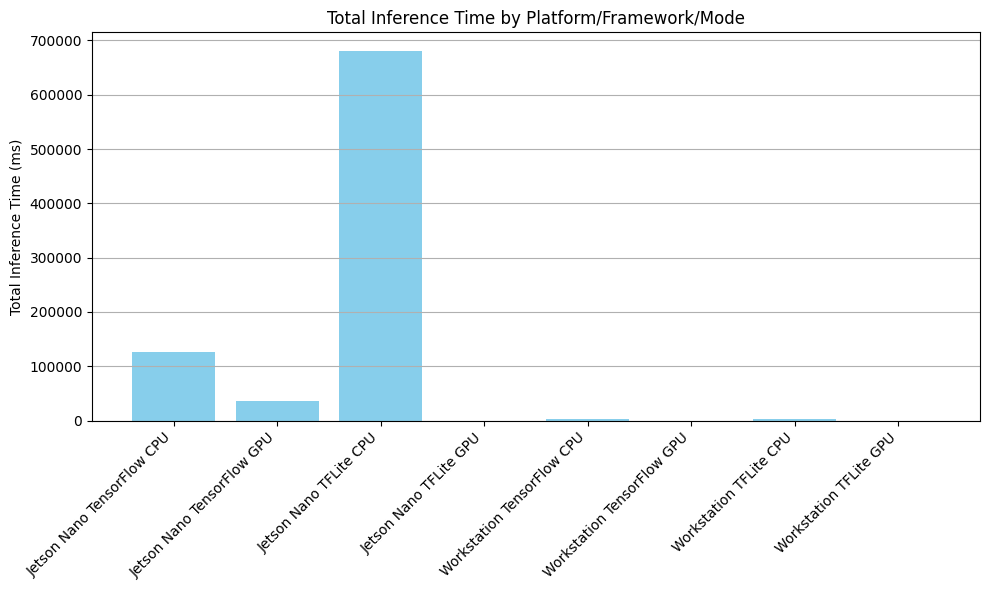

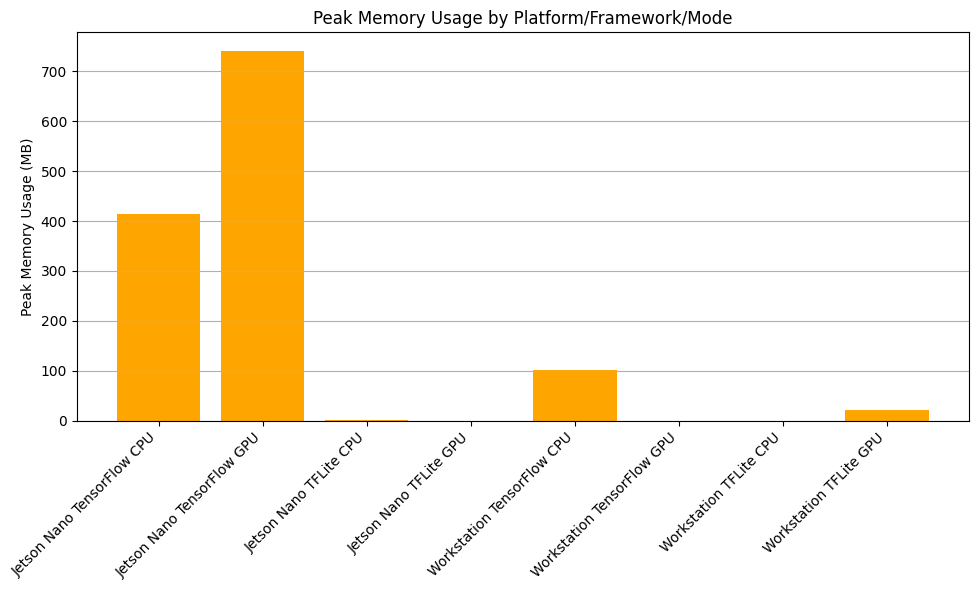

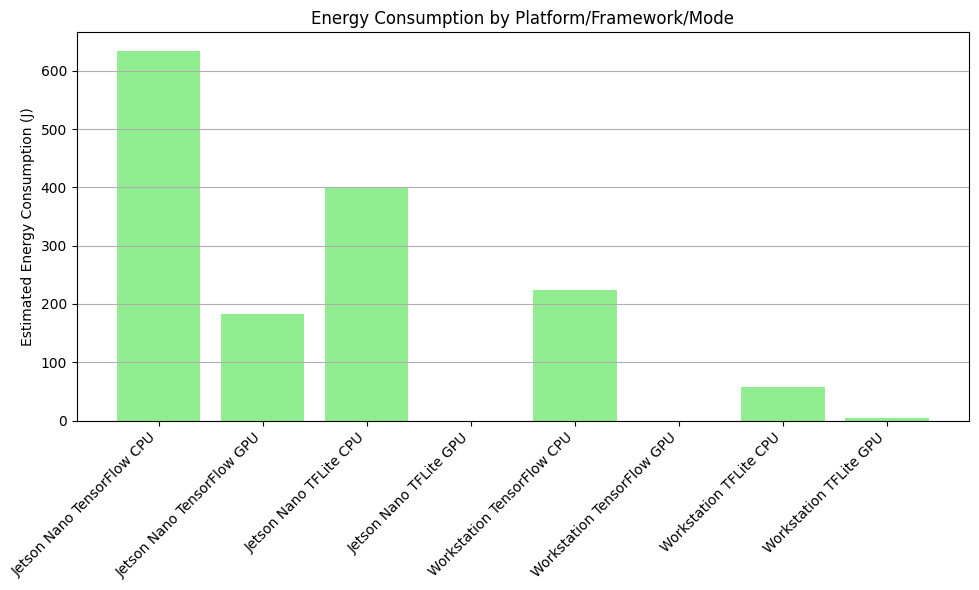

In [12]:

df = pd.DataFrame(data)

# Crear etiquetas combinadas para el eje x
df["Label"] = df["Platform"] + " " + df["Framework"] + " " + df["Execution Mode"]

# Graficar tiempo promedio
plt.figure(figsize=(10, 6))
plt.bar(df["Label"], df["Total Time (ms)"], color='skyblue')
plt.ylabel("Total Inference Time (ms)")
plt.title("Total Inference Time by Platform/Framework/Mode")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Graficar memoria pico
plt.figure(figsize=(10, 6))
plt.bar(df["Label"], df["Peak Memory (MB)"], color='orange')
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Peak Memory Usage by Platform/Framework/Mode")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Graficar energía estimada
plt.figure(figsize=(10, 6))
plt.bar(df["Label"], df["Energy (J)"], color='lightgreen')
plt.ylabel("Estimated Energy Consumption (J)")
plt.title("Energy Consumption by Platform/Framework/Mode")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

After evaluate the model in the different platforms and with different framework:

**a. TensorFlow Lite on Workstation**

TFLite on the Workstation offers the most efficient setup, especially in GPU mode, achieving extremely low inference time (0.2 ms), low peak memory usage (20.9 MB), and minimal energy consumption (4.2 J). The CPU execution was also efficient (3710 ms total for 3132 images ≈ 1.18 ms/image), with negligible memory usage and moderate energy consumption (58.12 J). These results are consistent with TFLite’s design, which prioritizes lightweight, optimized inference of pre-trained models.

**b. TensorFlow on Workstation**

TensorFlow on the Workstation performs reasonably well, with inference times of 2977 ms on CPU (~0.95 ms/image) and even better on GPU. However, it consumes significantly more memory (101.25 MB) and energy (223.24 J) than its TFLite counterpart. This aligns with TensorFlow’s emphasis on flexibility and generality at the cost of higher computational load.

**c. TensorFlow on Jetson Nano**

TensorFlow on the Jetson Nano shows clear limitations in an embedded context. Inference on the CPU took 126 seconds (40.3 ms/image), with high energy consumption (634.2 J) and substantial memory usage (413.4 MB). GPU execution improved performance (11.7 ms/image) and reduced energy use (182.7 J), but still lags far behind desktop-class hardware. This highlights the trade-off between capability and power in edge devices.

**d. TensorFlow Lite on Jetson Nano**

TFLite on the Jetson Nano CPU performed poorly, with extremely high inference times (~217 ms/image), indicating severe bottlenecks—likely due to ARM CPU limitations and memory bandwidth constraints. The GPU delegate failed to produce valid results (0 inference time, 0 memory/energy reported), suggesting compatibility issues or unsupported operations on the Jetson Nano’s Maxwell GPU. This underscores the current limitations of deploying TFLite GPU inference on certain embedded platforms.


